In [1]:
import os
#import svmbir
import numpy as np
import glob
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
%matplotlib notebook  

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

from skimage.io import imread
import cv2

In [2]:
def zero_one_Norm(im):
    return (im.copy()-im.min())/(im.max()-im.min())

In [3]:
def load_hyper(lst, st, end):
    lst.sort()
    temp = imread(lst[0])
    w, h = temp.shape
    data = np.zeros((w-20, h-20, end-st))
    
    for i in range(end-st):
        data[:, :, i] = imread(lst[st+i])[10:-10, 10:-10]
        
    return data.swapaxes(0,1)

In [6]:
glob.glob(os.path.join("/Users/j35/SNS/SNAP/IPTS-27829"))

['/Users/j35/SNS/SNAP/IPTS-27829']

In [7]:
class file_picker():
    def __init__(self, ipts):
        self.ipts = ipts
        self.list_save = []
        
        _optlist = glob.glob(os.path.join("/Users/j35/SNS/SNAP/IPTS-{}".format(self.ipts), '*'))
        self.drop = widgets.Dropdown(layout={'width': 'initial'}, options = _optlist,
                                     style={'description_width': 'initial'}, description = "path")
        self.path_list = {}
        
        button = widgets.Button(layout={'width': 'initial'}, description="open")
        button.on_click(self.on_button_clicked)
        
        return_button = widgets.Button(layout={'width': 'initial'}, description="return")
        return_button.on_click(self.set_return_button_cliked)
        path_buttons = widgets.HBox([button, return_button])
        
        self.keyword = widgets.Text(placeholder='Type keywords', style={'description_width': 'initial'},
                                    description='String used for searching:')
        
        search_button = widgets.Button(layout={'width': 'initial'}, description="Search")
        search_button.on_click(self.set_search_button_clicked)
        search_box = widgets.HBox([self.keyword, search_button])        
        
        ob_button = widgets.Button(layout={'width': 'initial'}, description="Select as OB")
        ob_button.on_click(self.set_ob_button_clicked)
        
        proj_button = widgets.Button(layout={'width': 'initial'}, description="Select as Projection")
        proj_button.on_click(self.set_proj_button_clicked)
        set_buttons = widgets.HBox([ob_button, proj_button])
        
        ui = widgets.VBox([self.drop, path_buttons, search_box, set_buttons])
        display(ui)
        
    def on_button_clicked(self, b):  
        _optlist = glob.glob(os.path.join(self.drop.value, '*'))
        self.drop.options = _optlist        
    
    def set_return_button_cliked(self, b):
        _optlist = glob.glob(os.path.join(os.path.dirname(os.path.dirname(self.drop.value)), '*'))
        self.drop.options = _optlist
        
    def set_search_button_clicked(self, b):
        if self.list_save == []:
            self.list_save = self.drop.value
        
        _optlist = glob.glob(os.path.join(os.path.dirname(self.list_save), 
                                          '*{}*'.format(self.keyword.value)))
        self.drop.options = _optlist
    
    def set_ob_button_clicked(self, b):
        self.path_list["ob"] = self.drop.value
        print("ob data path is: {}".format(self.path_list["ob"]))
        
    def set_proj_button_clicked(self, b):
        self.path_list["proj"] = self.drop.value
        print("projection data path is: {}".format(self.path_list["proj"]))
        

In [8]:
class bbox_select():
    def __init__(self,im):
        self.im = im
        self.Pts = []
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        
        new_poly_button = widgets.Button(layout={'width': 'initial'}, description="Selection Done, Next Region")
        display(new_poly_button)
        new_poly_button.on_click(self.on_button_clicked)
        
        disconnect_button = widgets.Button(description="Disconnect mpl")
        display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(0),3)
        return img

    def onclick(self, event):
        #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig                
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
            
    def on_button_clicked(self, b):
        self.Pts.append(self.selected_points)
        
        X = [coor[0] for coor in bs.Pts[-1]]
        Y = [coor[1] for coor in bs.Pts[-1]]
        x, y, = (np.min(X) + np.max(X))/2, (np.min(Y) + np.max(Y))/2
        self.im = cv2.putText(self.img.get_array().copy(), str(len(self.Pts)), [int(x),int(y)], 
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0), 4)
        self.fig                
        self.img.set_data(self.im)
        self.selected_points = []
    
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

## Hyperpspectrum Analysis
### - Load OpenBeam [m\*n\*s] s is number of wavelength
### - Load projection @ x-degree [m\*n\*s] s is number of wavelength
### - Load wavelength information [s\*1] s is number of wavelength
### - Proj/OB --> display --> select RoI
### - Plot selected spectrum

In [10]:
f = file_picker(27829) #26984 #25265

projection data path is: /Users/j35/SNS/SNAP/IPTS-27829/Free_wire_d0_normalized
ob data path is: /Users/j35/SNS/SNAP/IPTS-27829/Open_beam1_10C


In [11]:
print("Selected: {}".format(f.path_list["ob"]))
ob_lst = glob.glob(os.path.join(f.path_list["ob"], "Run*/*.tif*"))

print("Selected: {}".format(f.path_list["proj"]))
proj_lst = glob.glob(os.path.join(f.path_list["proj"], "Run*/*.tif*"))

Selected: /Users/j35/SNS/SNAP/IPTS-27829/Open_beam1_10C
Selected: /Users/j35/SNS/SNAP/IPTS-27829/Free_wire_d0_normalized


In [13]:
# df = pd.read_csv('./wavelength_202212.csv')
# wav_info = df["wavelength"].values
# plt.figure(figsize=(10, 3))
# plt.plot(wav_info, '.', markersize = 1)
# plt.xlabel('wavelength index')
# plt.xlabel('wavelength/Ang')

- Please set the wavelength indexes
    - wav_st: start index; wav_end: end index
- Load hyperpsctral data (OB and Projection) at selectec wavelength range

In [14]:
wav_st, wav_end = 70, 1427

hyper_proj = load_hyper(proj_lst, wav_st, wav_end)
hyper_ob = load_hyper(ob_lst, wav_st, wav_end)

IndexError: list index out of range

- Please set the normalization type
    - ratio: $\frac{Projection}{OpenBeam}$
    - log: $-log(\frac{Projection}{OpenBeam})$

In [15]:
ob_factor = 1
norm_type = 'trans' # log
print("Normalization: {}".format(norm_type))
if norm_type == "trans":
    hyper_norm = hyper_proj/(ob_factor*hyper_ob)
    hyper_norm = np.nan_to_num(hyper_norm, nan=0, posinf=0, neginf=0)
else:
    hyper_norm = -np.log(hyper_proj/(ob_factor*hyper_ob)) 
    hyper_norm = np.nan_to_num(hyper_norm, nan=0, posinf=0, neginf=0)

Normalization: trans


NameError: name 'hyper_proj' is not defined

In [16]:
bs = bbox_select(zero_one_Norm(hyper_norm.sum(axis = 2)))

NameError: name 'hyper_norm' is not defined

### If want to use the exact box shape in background 

In [574]:
index = -1 # box index
arr = np.array([bs.Pts[index]],'int')
off_set = np.array([[[-200,-150]]]) # offset from box to background
off_set_mat = np.repeat(off_set,[4], axis = 1)
im_ = im.copy()

<IPython.core.display.Javascript object>


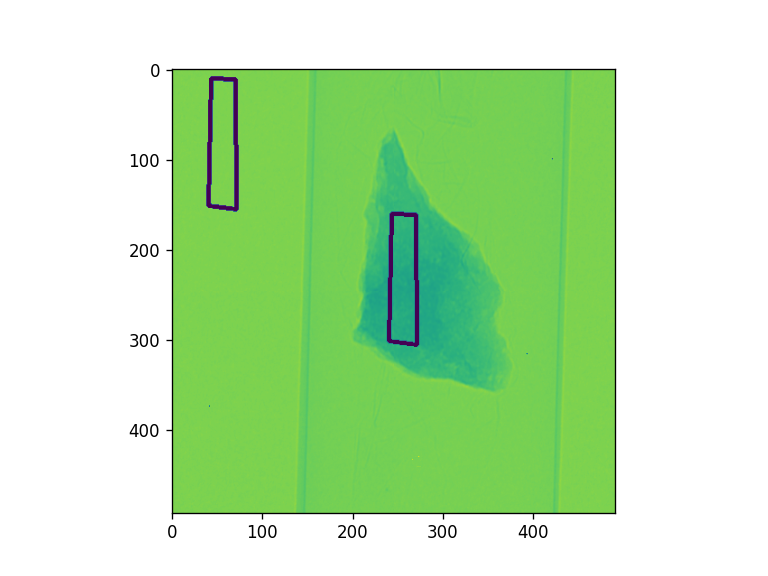

In [575]:
plt.figure()
cv2.polylines(im_,[arr],True,(0),3)
cv2.polylines(im_,[arr+off_set_mat],True,(0),3)
plt.imshow(im_)

In [576]:
# append new background box into points group
new_pt = (arr+off_set_mat)[0].tolist()
bs.Pts.append(new_pt)

## double check mask region

<IPython.core.display.Javascript object>


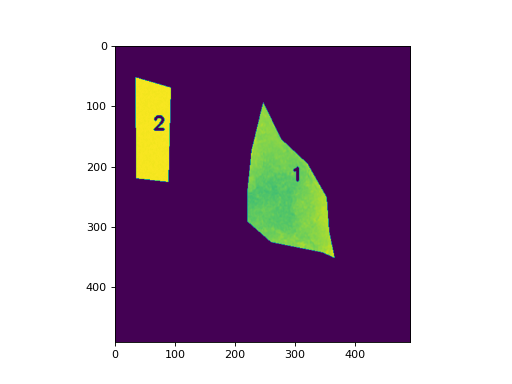

In [632]:
plt.figure()
Masks = []
temp = 0
for idx, pt in zip(range(len(bs.Pts)), bs.Pts[:]):
    arr = np.array([pt],'int')
    im = zero_one_Norm(hyper_norm.sum(axis = 2))
    mask = cv2.fillPoly(np.zeros(im.shape,np.uint8),arr,[1,1,1])
    Masks.append(mask)
    temp+=mask
    
    X = [coor[0] for coor in pt]
    Y = [coor[1] for coor in pt]
    x, y, = (np.min(X) + np.max(X))/2, (np.min(Y) + np.max(Y))/2
    
    temp = cv2.putText(temp.copy(), str(idx+1), [int(x),int(y)], 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0), 4)
plt.imshow(im*temp) #temp

# test matplotlib selection 

In [17]:
list_files = glob.glob("/Users/j35/HFIR/CG1D/IPTS-30750/23_06_10_right/*.tiff")

In [18]:
assert len(list_files) > 0

In [20]:
first_file = list_files[0]

In [21]:
from PIL import Image

In [23]:
data = np.asarray(Image.open(first_file))

<IPython.core.display.Javascript object>


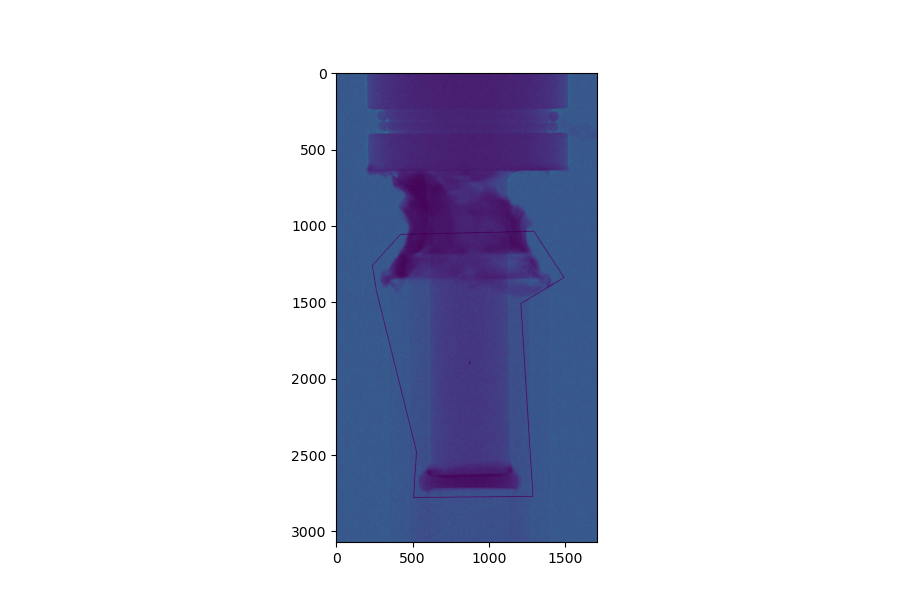

Button(description='Selection Done, Next Region', layout=Layout(width='initial'), style=ButtonStyle())

Button(description='Disconnect mpl', style=ButtonStyle())

In [27]:
bs = bbox_select(data)

TypeError: 'list' object is not callable